# Lab 11 (Evaluable)

We work for one of the most popular car buying and selling platforms in the world. From the product team they want to introduce a price recommender for the user based on the qualities of the car they want to sell. They have asked the Data Science team to tackle the challenge including:
- An exhaustive analysis of the data of the vehicles introduced in the platform in the past.
- The development of a predictive pricing model.
- The creation of a streamlit app that allows you to view the results of the analysis and interact with the model.
- Adding an explainability tab to the app so that all users can understand why each price is recommended to them.

# Practice Information:
**Due date:** By end of November, 29th (23:55h)

**Submission procedure:** via Moodle.

**Name:** Guillem Escriba Molto

**NIA:** 242123

### Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from random import seed
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
#from xgboost import XGBRegressor
import lightgbm as lgb
import pickle

import warnings
warnings.simplefilter('ignore')

sns.set_palette("icefire")

: 

### Read the Data

In [44]:
df = pd.read_csv("car_ad_display.csv", encoding = "ISO-8859-1", sep=";").drop(columns='Unnamed: 0')
df.head(3)

,car,price,body,mileage,engV,engType,registration,year,model,drive
0,Ford,15500.0,crossover,68,2.5,Gas,yes,2010,Kuga,full
1,Mercedes-Benz,20500.0,sedan,173,1.8,Gas,yes,2011,E-Class,rear
2,Mercedes-Benz,35000.0,other,135,5.5,Petrol,yes,2008,CL 550,rear


## Data Gathering and Data Wrangling

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8849 entries, 0 to 8848
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   car           8849 non-null   object 
 1   price         8849 non-null   float64
 2   body          8849 non-null   object 
 3   mileage       8849 non-null   int64  
 4   engV          8849 non-null   float64
 5   engType       8849 non-null   object 
 6   registration  8849 non-null   object 
 7   year          8849 non-null   int64  
 8   model         8849 non-null   object 
 9   drive         8467 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 691.5+ KB


In [46]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8467 entries, 0 to 8848
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   car           8467 non-null   object 
 1   price         8467 non-null   float64
 2   body          8467 non-null   object 
 3   mileage       8467 non-null   int64  
 4   engV          8467 non-null   float64
 5   engType       8467 non-null   object 
 6   registration  8467 non-null   object 
 7   year          8467 non-null   int64  
 8   model         8467 non-null   object 
 9   drive         8467 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 727.6+ KB


#### EX1: How many different entries do we have for the car names column?

In [47]:
car_names = df['car'].unique()
print(car_names)
print(len(car_names))

['Ford' 'Mercedes-Benz' 'Nissan' 'Honda' 'Renault' 'BMW' 'Volkswagen'
 'Audi' 'Chrysler' 'Jaguar' 'Mitsubishi' 'Kia' 'Porsche' 'Toyota'
 'Hyundai' 'Opel' 'Chevrolet' 'Skoda' 'Land Rover' 'Daewoo' 'Mazda'
 'Lexus' 'Infiniti' 'Subaru' 'VAZ' 'Alfa Romeo' 'Smart' 'Peugeot' 'Suzuki'
 'Chery' 'Bentley' 'Volvo' 'ZAZ' 'Citroen' 'Dodge' 'Fiat' 'Jeep'
 'SsangYong' 'Seat' 'MINI' 'Dacia' 'Hummer' 'Geely' 'Maserati' 'BYD'
 'Cadillac' 'Acura' 'Aston Martin' 'Tesla' 'Rover' 'GAZ' 'GMC' 'Lincoln'
 'Moskvich-AZLK' 'FAW' 'UAZ' 'TATA' 'ZX' 'Lifan' 'Mercury' 'Groz'
 'Great Wall' 'Moskvich-Izh' 'Saab' 'Lancia' 'Aro' 'Ferrari' 'Bogdan'
 'Dadi' 'Rolls-Royce' 'MG' 'Samand' 'JAC' 'Samsung' 'Lamborghini'
 'Daihatsu' 'Hafei' 'SMA' 'ËUAZ' 'Isuzu' 'Huanghai' 'Wartburg' 'Buick']
83


**Solution:** There are a total of 84 different car names as we can see in the above cell.

#### Let's reduce the number of car names with a cutoff

In [48]:
def shorten_categories(categories, cutoff):
    categorical_map = {}
    for i in range(len(categories)):
        if categories.values[i] >= cutoff:
            categorical_map[categories.index[i]] = categories.index[i]
        else:
            categorical_map[categories.index[i]] = 'Other'
    return categorical_map

In [49]:
car_map = shorten_categories(df.car.value_counts(), 10)
df['car'] = df['car'].map(car_map)
df.car.value_counts()

Volkswagen       833
Mercedes-Benz    772
BMW              611
Toyota           498
Renault          430
VAZ              426
Audi             403
Opel             368
Skoda            338
Hyundai          329
Ford             315
Mitsubishi       293
Nissan           281
Chevrolet        226
Daewoo           205
Kia              197
Honda            193
Mazda            173
Peugeot          167
Lexus            160
Land Rover       133
Fiat             110
Subaru           105
Citroen           94
Other             93
ZAZ               88
Porsche           82
Infiniti          60
Suzuki            53
Geely             50
Chery             47
Smart             44
SsangYong         43
Seat              36
Volvo             31
Jeep              25
Chrysler          22
GAZ               20
Jaguar            18
UAZ               18
Bentley           15
MINI              15
Acura             13
Dodge             13
Alfa Romeo        11
Dacia             10
Name: car, dtype: int64

#### EX2: Do the same with car model feature!

In [50]:
# CODE HERE 

model_map = shorten_categories(df.model.value_counts(), 10)
df['model'] = df['model'].map(model_map)
df.model.value_counts()

Other         1679
E-Class        178
A6             151
Camry          122
Vito ïàññ.     114
              ... 
Ibiza           10
Swift           10
Corsa           10
S 550           10
L 200           10
Name: model, Length: 227, dtype: int64

#### EX3: Plot a bar char of the TOP 10 most expensive cars.
#### Which is the mean price per car brand?  (for the top 10 most expensive)

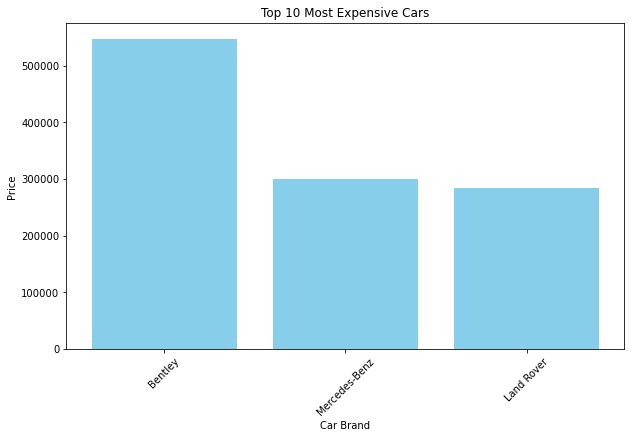

Mean Price Per Car Brand (Top 10 Most Expensive):
car
Bentley          451359.4
Land Rover       285000.0
Mercedes-Benz    285000.0
Name: price, dtype: float64


In [51]:
# CODE HERE 
top10_expensive = df.sort_values(by='price', ascending=False).head(10)

# Plotting the bar chart for the top 10 most expensive cars
plt.figure(figsize=(10, 6))
plt.bar(top10_expensive['car'], top10_expensive['price'], color='skyblue')
plt.xlabel('Car Brand')
plt.ylabel('Price')
plt.title('Top 10 Most Expensive Cars')
plt.xticks(rotation=45)
plt.show()

# Calculating mean price per car brand for the top 10 most expensive cars
mean_price_per_brand = top10_expensive.groupby('car')['price'].mean()
print("Mean Price Per Car Brand (Top 10 Most Expensive):")
print(mean_price_per_brand)

#### Let's analyze each variable distribution (except for car and model)

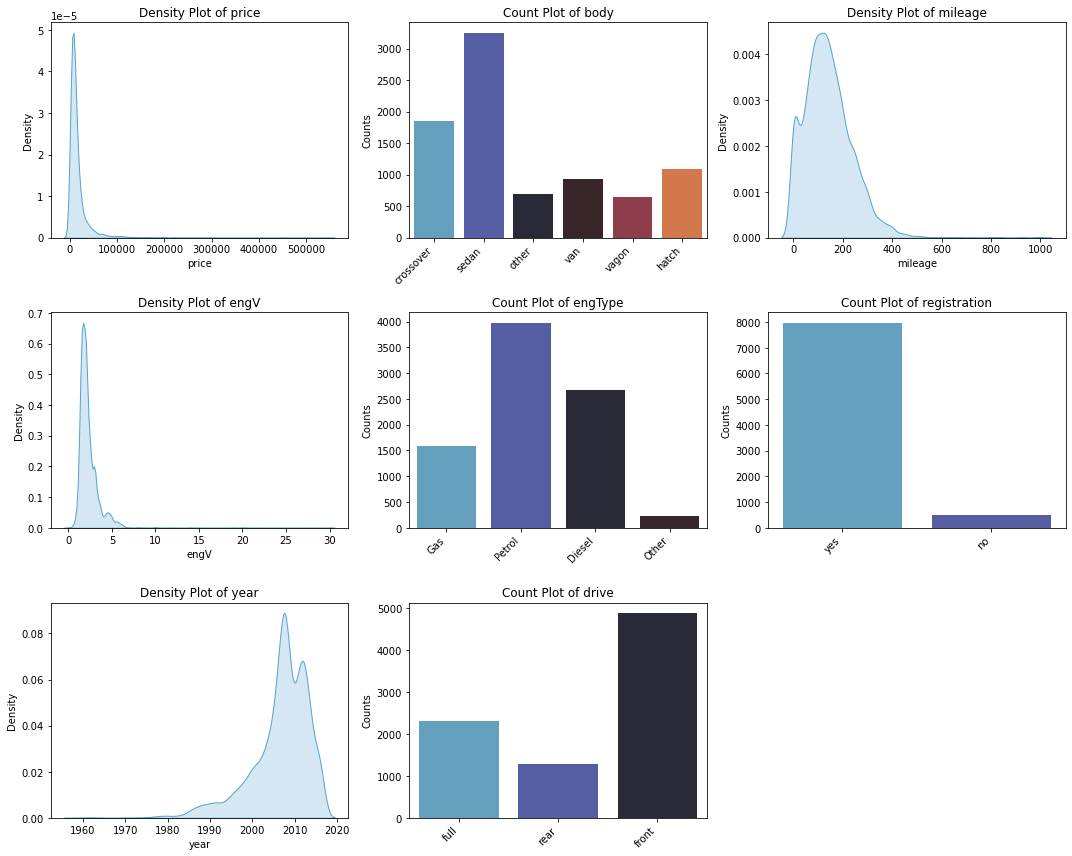

In [52]:
# Define the type of plot for each column based on the data type
plot_types = {}
columns = [x for x in df.columns if x not in ["car", "model"]]

for col in columns:
    if df[col].dtype == 'object':  # Categorical columns
        plot_types[col] = 'bar'
    else:
        unique_values = df[col].nunique()
        if unique_values < 10:  # Discrete columns
            plot_types[col] = 'bar'
        else:  # Continuous columns
            plot_types[col] = 'kde'

n_cols = 3
n_rows = (len(columns) + 2) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten()

# Plot each column in the dataframe
for i, col in enumerate(columns):
    ax = axes[i]
    if plot_types[col] == 'bar':
        # For categorical and discrete data, use a count plot (bar chart)
        sns.countplot(x=col, data=df, ax=ax)
        ax.set_title(f'Count Plot of {col}')
        ax.set_xlabel('')
        ax.set_ylabel('Counts')
        plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    else:
        # For continuous data, use a density plot
        sns.kdeplot(df[col], ax=ax, fill=True)
        ax.set_title(f'Density Plot of {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Density')

# Hide any unused subplots
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

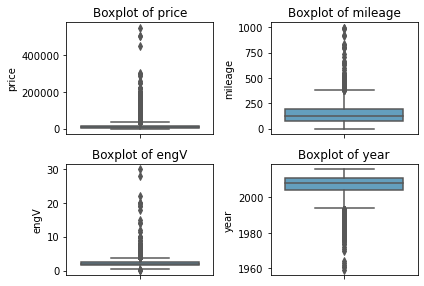

In [53]:
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns

n_cols = 2
n_rows = (len(numeric_columns) + 2) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 2))
axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    sns.boxplot(y=col, data=df, ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')

for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

#### Let's analyze each variable behaviour with respect to the target (price)

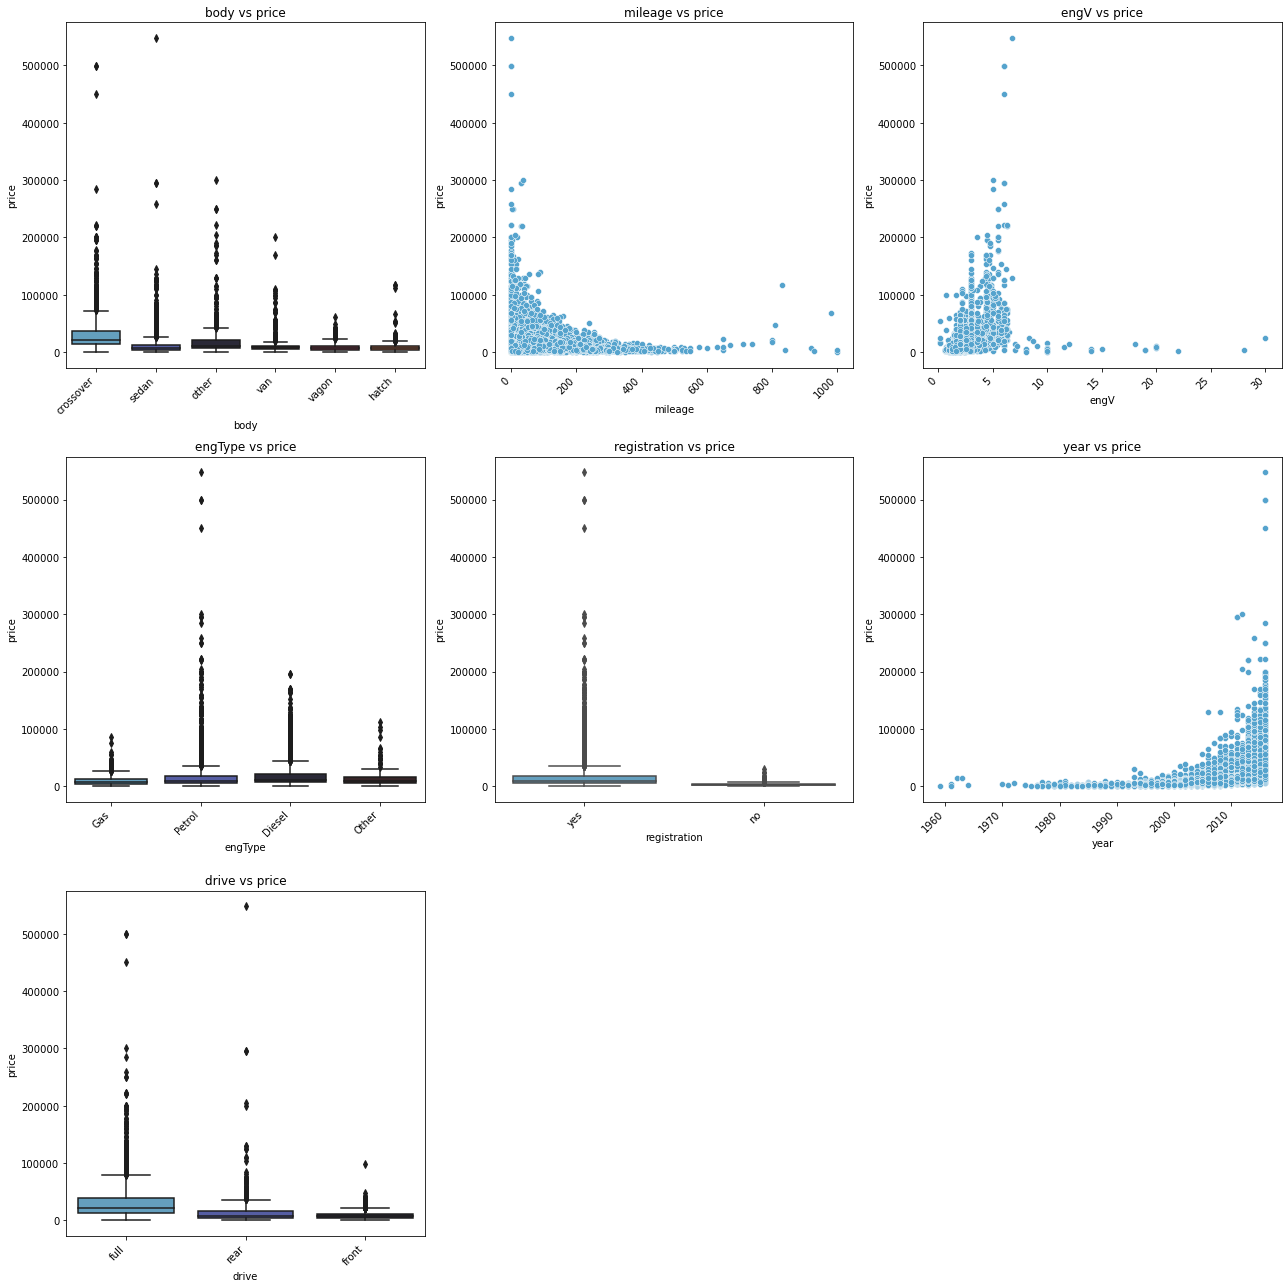

In [54]:
target = 'price'
features = [x for x in df.columns if x not in ["car", "model", target]]

n_cols = 3
n_rows = (len(features) + 2) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 6))
axes = axes.flatten()

# Plot each feature against the target variable in the dataframe
for i, feature in enumerate(features):
    ax = axes[i]
    if df[feature].dtype == 'object' or df[feature].nunique() < 10:
        # For categorical data, use a boxplot or violin plot
        sns.boxplot(x=feature, y=target, data=df, ax=ax)
    else:
        # For numerical data, use a scatter plot
        sns.scatterplot(x=feature, y=target, data=df, ax=ax)
    ax.set_title(f'{feature} vs {target}')
    plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

# Hide any unused subplots
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

#### As we see, there are many outliers in the features and in the target data.
#### Let's get rid of outliers in the target

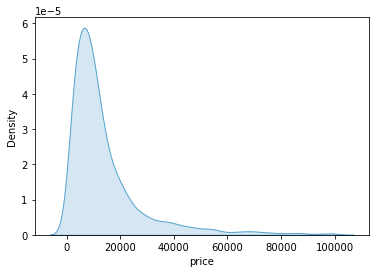

In [55]:
#Let's filter the prices between 1K and 100K
df = df[df["price"] <= 100000]
df = df[df["price"] >= 1000]

plt.figure(figsize=(6, 4))
sns.kdeplot(x="price", data=df, fill=True)
ax.set_title(f'Count Plot of Price')
plt.show()

#### Let's get rid of outliers in the rest of the numeric features

In [56]:
#Let's filter the mileage over 600
df = df[df["mileage"] <= 600]

#Let's filter the engV over 7.5
df = df[df["engV"] <= 7.5]

#Let's filter the year over 1975
df = df[df["year"] >= 1975]

#### Check how the behaviour of the features with the target has changed

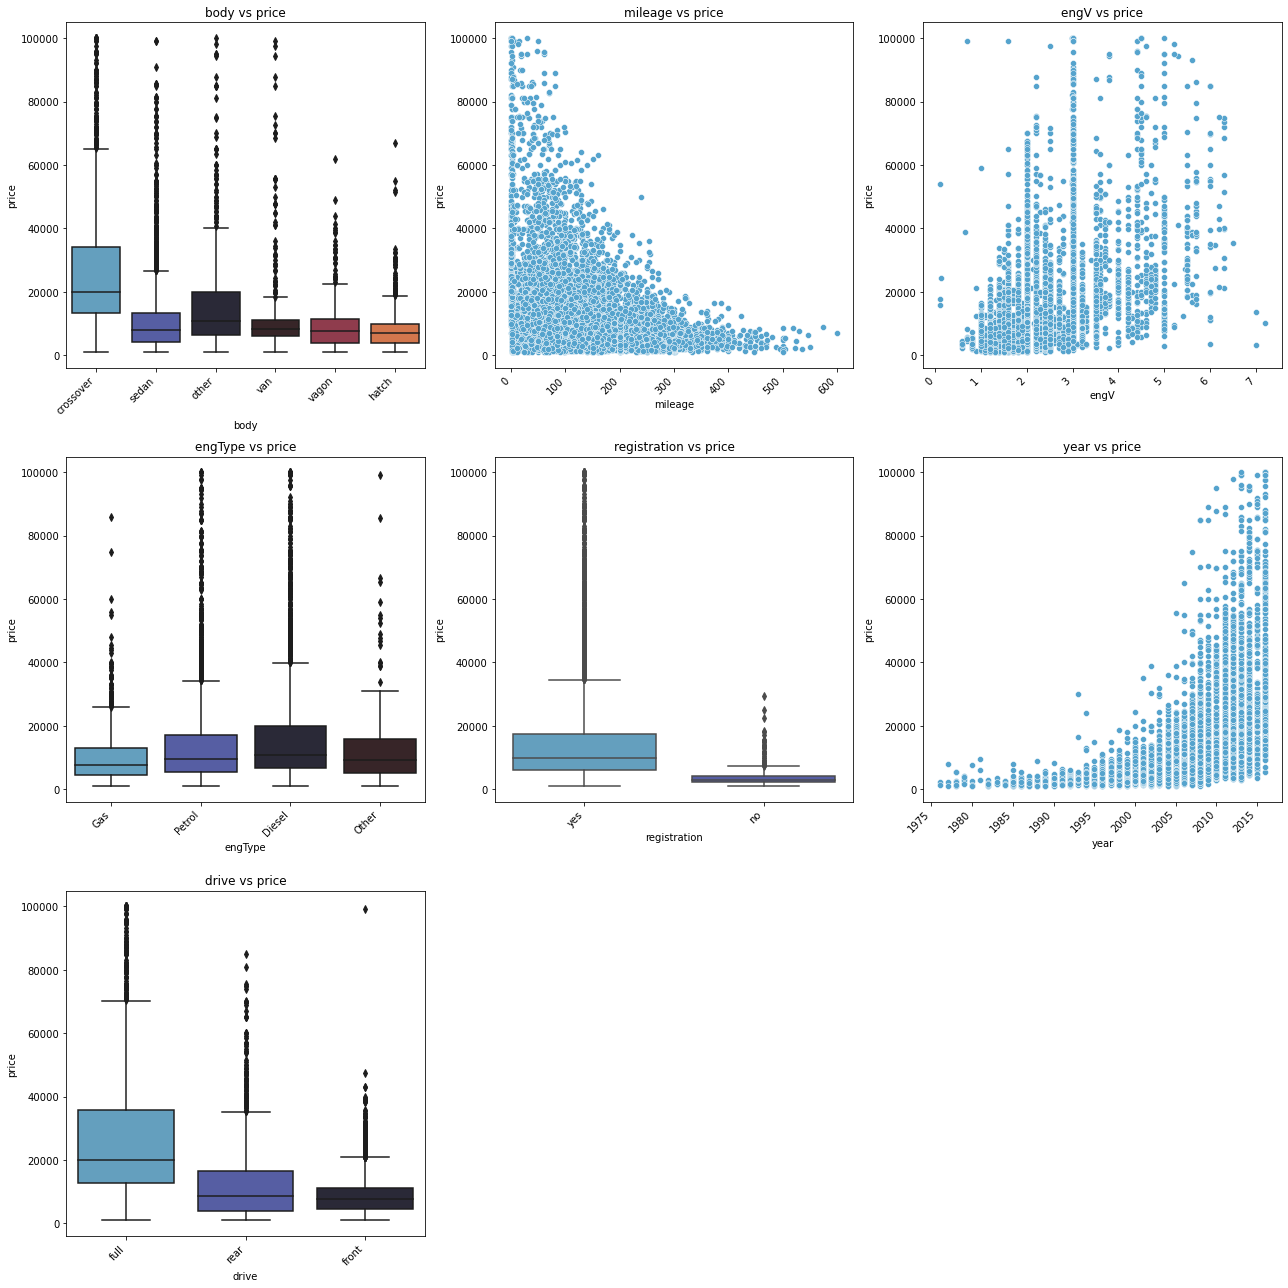

In [57]:
target = 'price'
features = [x for x in df.columns if x not in ["car", "model", target]]

n_cols = 3
n_rows = (len(features) + 2) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 6))
axes = axes.flatten()

# Plot each feature against the target variable in the dataframe
for i, feature in enumerate(features):
    ax = axes[i]
    if df[feature].dtype == 'object' or df[feature].nunique() < 10:
        # For categorical data, use a boxplot or violin plot
        sns.boxplot(x=feature, y=target, data=df, ax=ax)
    else:
        # For numerical data, use a scatter plot
        sns.scatterplot(x=feature, y=target, data=df, ax=ax)
    ax.set_title(f'{feature} vs {target}')
    plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

# Hide any unused subplots
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

#### EX4: Which of the features do you predict would be more important for estimating the price?

**Solution:** Apparentely the most important are the year with a positvie correaltion, the milleage, with a negative one, and registration. 

#### EX5: After all changes, How many rows are left?

In [58]:
# CODE HERE:
df.shape[0]

8224

**Solution:** There a total of 8596 rows.

### Let's prepare the data for model:

In [59]:
df_original = df.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8224 entries, 0 to 8848
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   car           8224 non-null   object 
 1   price         8224 non-null   float64
 2   body          8224 non-null   object 
 3   mileage       8224 non-null   int64  
 4   engV          8224 non-null   float64
 5   engType       8224 non-null   object 
 6   registration  8224 non-null   object 
 7   year          8224 non-null   int64  
 8   model         8224 non-null   object 
 9   drive         8224 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 964.8+ KB


In [60]:
#Let's encode the string features:

le_car = LabelEncoder()
df['car'] = le_car.fit_transform(df['car'])
print('*CAR: \n', df["car"].unique(), '\n')

le_body = LabelEncoder()
df['body'] = le_body.fit_transform(df['body'])
print('*BODY: \n', df["body"].unique(), '\n')

le_engType = LabelEncoder()
df['engType'] = le_engType.fit_transform(df['engType'])
print('*EngType: \n', df["engType"].unique(), '\n')

le_drive = LabelEncoder()
df['drive'] = le_drive.fit_transform(df['drive'])
print('*DRIVE: \n', df["drive"].unique(), '\n')

*CAR: 
 [13 26 28 16 33  3 43  2  7 19 27 21 32 40 17 29  6 35 22 10 25 23 18 38
 42  1 36 31 39  5  4 44 45  8 11 12 20 37 34 24  9 30 15  0 14 41] 

*BODY: 
 [0 3 2 5 4 1] 

*EngType: 
 [1 3 0 2] 

*DRIVE: 
 [1 2 0] 



In [61]:
#Encode registration string feature into a int boolean feature
yes_l = ['yes', 'YES', 'Yes', 'y', 'Y']
df['registration'] = np.where(df['registration'].isin(yes_l), 1, 0)
df['registration'].value_counts()

1    7740
0     484
Name: registration, dtype: int64

In [62]:
# We will drop 'model' feature as there is no simple way to handle that amount of unique values.
df = df.drop(columns='model')

In [63]:
print(df.info())
df.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8224 entries, 0 to 8848
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   car           8224 non-null   int32  
 1   price         8224 non-null   float64
 2   body          8224 non-null   int32  
 3   mileage       8224 non-null   int64  
 4   engV          8224 non-null   float64
 5   engType       8224 non-null   int32  
 6   registration  8224 non-null   int32  
 7   year          8224 non-null   int64  
 8   drive         8224 non-null   int32  
dtypes: float64(2), int32(5), int64(2)
memory usage: 739.9 KB
None


,car,price,body,mileage,engV,engType,registration,year,drive
0,13,15500.0,0,68,2.5,1,1,2010,1
1,26,20500.0,3,173,1.8,1,1,2011,2
2,26,35000.0,2,135,5.5,3,1,2008,2


#### EX6: Now that all data is in numeric data type, Plot the correlation matrix among features:

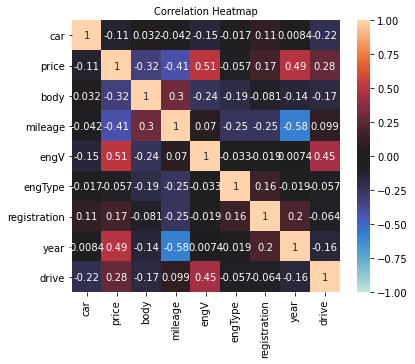

In [64]:
# CODE HERE

corr = df.corr()
plt.figure(figsize=(6, 5))
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, cmap='icefire')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':10});

#### EX7: Which variables are more correlated with the target?

**Solution:** The variables with the highest correlation with the target, either positive or negative are: engV, year, mileage and body.

## Model training

In [65]:
#Let's split train and test data
X = df.drop("price", axis=1)
y = df["price"]
X_train, X_test, y_train, y_test=train_test_split(X, y, random_state=42)

#### Ensure X and Y have the same lenght for both train and test

In [66]:
print("Lenght X_train:",len(X_train))
print("Length y_train:", len(y_train))
print("Lenght X_test:",len(X_test))
print("Length y_test:", len(y_test))

Lenght X_train: 6168
Length y_train: 6168
Lenght X_test: 2056
Length y_test: 2056


#### Try different models:

In [67]:
#Linear Regression:

linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
display(linear_reg)

y_pred_test = linear_reg.predict(X_test)
error = np.sqrt(mean_squared_error(y_test, y_pred_test))
print("${:,.02f}".format(error))

LinearRegression()

$9,344.01


In [68]:
#Random Forest:

random_forest_reg = RandomForestRegressor(random_state=0)
random_forest_reg.fit(X_train, y_train)
display(random_forest_reg)

y_pred_test = random_forest_reg.predict(X_test)
error = np.sqrt(mean_squared_error(y_test, y_pred_test))
print("${:,.02f}".format(error))

RandomForestRegressor(random_state=0)

$4,322.87


In [69]:
#XGBoost:

lgb_reg = lgb.LGBMRegressor()
lgb_reg.fit (X_train, y_train)
display(lgb_reg)

y_pred_test=lgb_reg.predict(X_test)
error = np.sqrt(mean_squared_error(y_test, y_pred_test))
print("${:,.02f}".format(error))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 410
[LightGBM] [Info] Number of data points in the train set: 6168, number of used features: 8
[LightGBM] [Info] Start training from score 14393.636463


LGBMRegressor()

$4,109.40


#### it seems that LightGBM performs better for this use case, so let's continue with the this algorithm grid search for choosing the best parameters (this can take some minutes):

In [70]:
# Add as many parametrers as you want
max_depth = [2, 8, 12]
n_estimators = [50, 100, 300]
learning_rate = [0.1]

parameters = {
    "max_depth": max_depth,
    "n_estimators": n_estimators,
    "learning_rate": learning_rate}

lgb_reg = lgb.LGBMRegressor(random_state=42, force_row_wise=True)

# Grid Search
gs = GridSearchCV(lgb_reg, parameters, scoring='neg_mean_squared_error')
gs.fit(X_train, y_train)

[LightGBM] [Info] Total Bins 409
[LightGBM] [Info] Number of data points in the train set: 4934, number of used features: 8
[LightGBM] [Info] Start training from score 14477.580131
[LightGBM] [Info] Total Bins 407
[LightGBM] [Info] Number of data points in the train set: 4934, number of used features: 8
[LightGBM] [Info] Start training from score 14271.986943
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 4934, number of used features: 8
[LightGBM] [Info] Start training from score 14387.008520
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 4935, number of used features: 8
[LightGBM] [Info] Start training from score 14407.830177
[LightGBM] [Info] Total Bins 407
[LightGBM] [Info] Number of data points in the train set: 4935, number of used features: 8
[LightGBM] [Info] Start training from score 14423.767560
[LightGBM] [Info] Total Bins 409
[LightGBM] [Info] Number of data points in the train set: 4934

GridSearchCV(estimator=LGBMRegressor(force_row_wise=True, random_state=42),
             param_grid={'learning_rate': [0.1], 'max_depth': [2, 8, 12],
                         'n_estimators': [50, 100, 300]},
             scoring='neg_mean_squared_error')

In [71]:
lgb_reg = gs.best_estimator_
lgb_reg.fit(X_train, y_train)

y_pred_test = lgb_reg.predict(X_test)

error = np.sqrt(mean_squared_error(y_test, y_pred_test))
print("${:,.02f}".format(error))

print("The R2_score is:", r2_score(y_test, y_pred_test))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Total Bins 410
[LightGBM] [Info] Number of data points in the train set: 6168, number of used features: 8
[LightGBM] [Info] Start training from score 14393.636463
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
$3,854.79
The R2_score is: 0.9252673105965709


#### EX8: Test with an invented example (just run the code and answer the questions):

In [72]:
A = []
Q = [
    "Enter your brand car "+  str(list(df_original['car'].unique()[:5]))[:-1]+" , ...]: ",
    "Enter the body category of your car "+ str(list(df_original['body'].unique()))+': ',
    "Enter the milage: ",
    "Enter the engV (use '.' as decimal): ",
    "Enter the engType "+ str(list(df_original['engType'].unique()))+': ',
    "Enter if it registered (yes/no): ",
    "Enter the year of the car: ",
    "Enter the drive type of the car "+ str(list(df_original['drive'].unique()))+': ']

for q in Q:
    a = input(q)
    A.append(a)

print("Your answers are:", A)

Your answers are: ['Ford', 'sedan', '1000', '8', 'Gas', 'no', '2020', 'full']


In [73]:
X_sample = np.array([A])

# Apply the encoder and data type corrections:
X_sample[:, 0] = str(X_sample[:, 0][0] if X_sample[:, 0][0] in list(df_original['car'].unique()) else 'Other')
X_sample[:, 0] = le_car.transform(X_sample[:,0])
X_sample[:, 1] = le_body.transform(X_sample[:,1])
X_sample[:, 4] = le_engType.transform(X_sample[:,4])
X_sample[:, 5] = int(1 if X_sample[:, 5][0] in yes_l else 0)
X_sample[:, 7] = le_drive.transform(X_sample[:,7])

X_sample = np.array([[
    int(X_sample[0, 0]),
    int(X_sample[0, 1]),
    int(X_sample[0, 2]),
    float(X_sample[0, 3]),
    int(X_sample[0, 4]),
    int(X_sample[0, 5]),
    int(X_sample[0, 6]),
    int(X_sample[0, 7])
]])

print('The encoded array is: ', X_sample)

The encoded array is:  [[1.30e+01 3.00e+00 1.00e+03 8.00e+00 1.00e+00 0.00e+00 2.02e+03 1.00e+00]]


In [74]:
y_pred_sample = lgb_reg.predict(X_sample)
print("Your car estimated price is: ","${:,.02f}".format(y_pred_sample[0]))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Your car estimated price is:  $44,656.86


### Store and read the model

In [75]:
# Store
data = {"model": lgb_reg, "le_car": le_car, "le_body": le_body, "le_engType":le_engType , "le_drive":le_drive}
with open('model.pkl', 'wb') as file:
    pickle.dump(data, file)

In [83]:
# Read
with open('model.pkl', 'rb') as file:
    data = pickle.load(file)

model = data["model"]
le_car = data["le_car"]
le_body = data["le_body"]
le_engType = data["le_engType"]
le_drive = data["le_drive"]

y_pred_sample = model.predict(X_sample)
print("Your car estimated price is: ","${:,.02f}".format(y_pred_sample[0]))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Your car estimated price is:  $44,656.86


## Explainability AI

As an excellent data scientist, we cannot conclude our work without understanding how the model works. In this section of the project, we will apply SHAP as a technique to understand, debug and explain our model.

### Global explainability

#### EX9: Train a Shap explainer and calculate the shap_values object for the X_test dataset. Print the shap values object of the first sample of X_test.

In [1]:
import shap

shap.initjs()
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)


display(X_test)
print(shap_values[0])

ModuleNotFoundError: No module named 'shap'

#### EX10: Which is the average price cost prediction for all cars?

In [87]:
# Making predictions
predicted_prices = model.predict(X)

# Calculating the average price
average_price = predicted_prices.mean()

print("The average price cost prediction for all cars is:", average_price)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
The average price cost prediction for all cars is: 14227.812227864993


#### Let's plot the summary plot and bar plot for global explainability of the model.

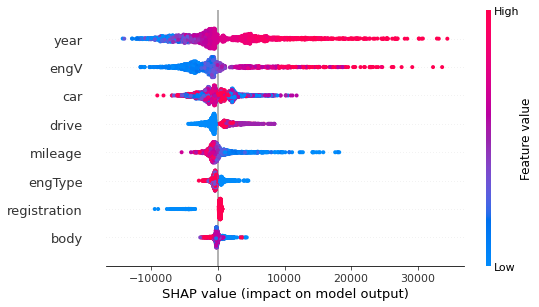

In [85]:
#Global Explainability
shap.summary_plot(shap_values, X_test)

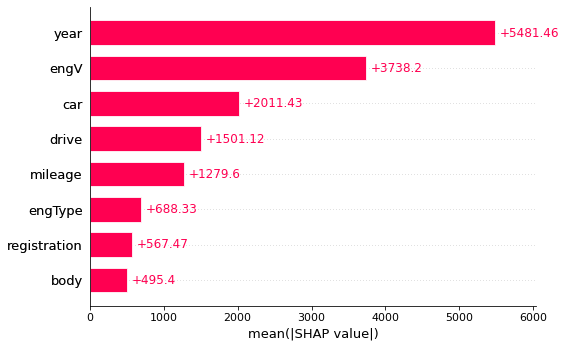

In [86]:
#Plot var: built from column 1 of all shap_values
shap.plots.bar(shap_values)

#### EX11: Which are your insights?

**Solution:** 
The SHAP summary plot indicates that the manufacture year is the most influential factor, with newer cars predicted to be more expensive. Engine volume and brand have complex effects on car prices, suggesting an interaction with other features. Mileage consistently lowers the price, and features like drive type, engine type, and registration status also contribute to the model's predictions but to a lesser extent.

#### Let's do deep dive in the variables `Mileage`, `engV` and `year`. 

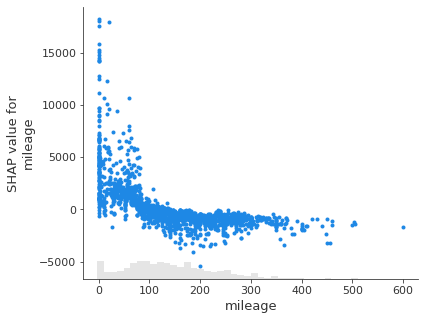

In [88]:
shap.plots.scatter(shap_values[:,"mileage"])

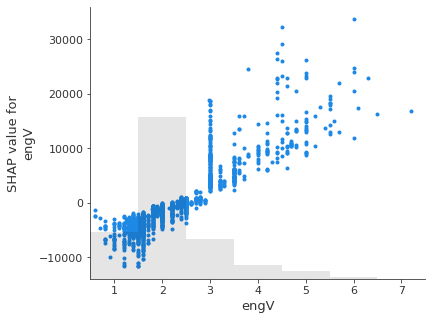

In [89]:
shap.plots.scatter(shap_values[:,"engV"])

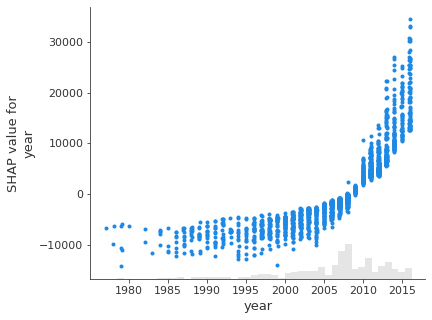

In [90]:
shap.plots.scatter(shap_values[:,"year"])

#### EX12: What are the most relevant insights abour the evolution of the features' values and their Shap values.

#### **Solution:** 

#### Let's analyze the relationship of the variables `engV` and `year` and their Shap values according to the value of `mileage`.

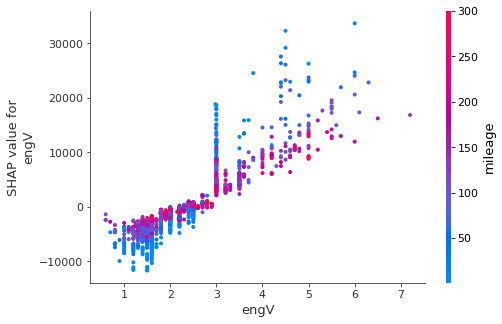

In [92]:
#Let's analyze the evolution of Shap values of engV based on mileage
shap.dependence_plot("engV", shap_values.values, X_test, interaction_index= "mileage")

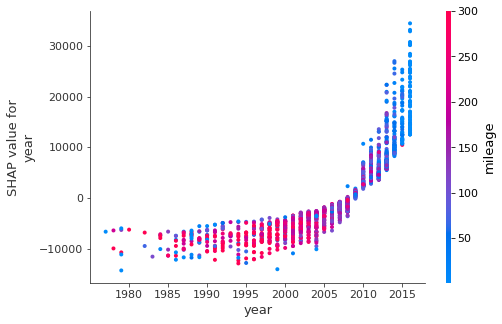

In [93]:
#Let's analyze the evolution of Shap values of engV based on mileage
shap.dependence_plot("year", shap_values.values, X_test, interaction_index= "mileage")

 #### EX13: What are the most relevant insights about the evolution of the features' values and their Shap values.

**Solution:**

### Local explainability

Local explainability facilitates the understanding of the prediction for some particular cases. In other words, XAI closes to a personalized prediction explainability. Let's use the first sample of X_test for the following steps.

#### Using the waterfall, force and decision plots, we can explain how the model works.

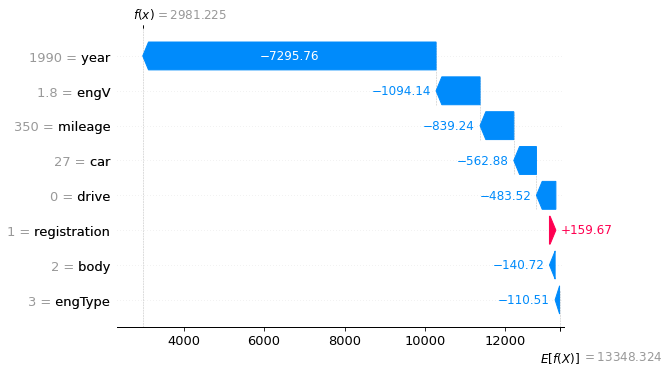

In [94]:
shap.plots.waterfall(shap_values[0])

In [95]:
shap.plots.force(shap_values[0])

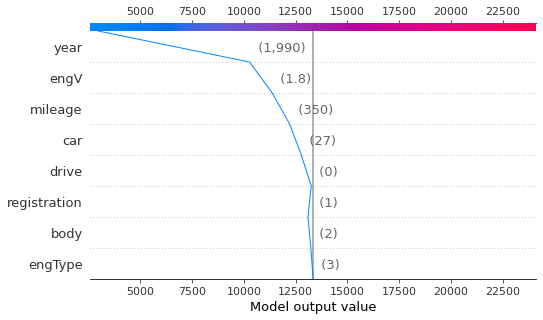

In [96]:
shap.decision_plot(shap_values[0].base_values,shap_values[0].values, X_test.iloc[0])